In [1]:
import os
import umap
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from copy import deepcopy
from torchvision import models
from tpot import TPOTRegressor
from tpot import TPOTClassifier
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from IPython.display import Image
from torch.optim import Adam, SGD
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import OneClassSVM, SVC
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

In [2]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood, SoftmaxLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [3]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [4]:
np.random.seed(1489)
torch.manual_seed(1489)
torch.cuda.manual_seed(1489)

In [8]:
PENGPATH = "/home/bakirillov/Data/CRISPR-CAD/Peng_offtargets/bty558-suppl_data/"
HPATH = "/home/bakirillov/Data/CRISPR-CAD/Haeussler/13059_2016_1012_MOESM2_ESM.tsv"
LOW = op.join(PENGPATH, "Supplementary file 1.xlsx")
HIGH = op.join(PENGPATH, "Supplementary file 1.xlsx")
NEG = op.join(PENGPATH, "Supplementary file 1.xlsx")

In [9]:
UNDERSAMPLE = False

In [12]:
low = pd.read_excel(op.join(PENGPATH, "Supplementary file 1.xlsx"), sheet_name=0, engine='openpyxl')
high = pd.read_excel(op.join(PENGPATH, "Supplementary file 1.xlsx"), sheet_name=1, engine='openpyxl')
neg = pd.read_excel(op.join(PENGPATH, "Supplementary file 1.xlsx"), sheet_name=2, engine='openpyxl')
low_strs = [a+","+b for a,b in zip(low["on-target site"], low["off-target site"])]
high_strs = [a+","+b for a,b in zip(high["on-target site"], high["off-target site"])]
neg_strs = [a+","+b for a,b in zip(neg["on-target site"], neg["no editing site"])]
low_high = list(set(low_strs+high_strs))
final_neg = []

In [13]:
if UNDERSAMPLE:
    for a in tqdm(low_high):
        suitable = list(
            filter(
                lambda x: x.split(",")[0] == a.split(",")[0] and x.split(",")[0] not in final_neg, 
                neg_strs
            )
        )
        final_neg.append(np.random.choice(suitable))
    final_neg = list(set(final_neg))
else:
    final_neg = neg_strs
pairs = np.array(low_high+final_neg)
labels = np.array([1]*len(low_high)+[0]*len(final_neg))

In [14]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([408260,    742]))

In [15]:
742/(408260+742)

0.001814172057838348

In [16]:
N_MISMATCHES = -1

In [17]:
if N_MISMATCHES != -1:
    n_mms = lambda x,y: np.sum([int(a != b) for a,b in zip(x,y)])
    worthy = np.array([n_mms(*a.split(",")) for a in pairs]) < N_MISMATCHES
    not_worthy = np.array([n_mms(*a.split(",")) for a in pairs]) > N_MISMATCHES
    pretraining_pairs = pairs[not_worthy]
    pretraining_labels = labels[not_worthy]
    pairs = pairs[worthy]
    labels = labels[worthy]

In [18]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([408260,    742]))

In [19]:
guides = np.unique([a.split(",")[0] for a in pairs])

In [20]:
folds = {a: np.array([a not in b for b in pairs]) for a in guides}

In [21]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([408260,    742]))

In [22]:
u = ImperfectMatchTransform("NGG", False, False, fold=False)

In [23]:
transformer = transforms.Compose(
    [
        u, ToTensor(True)
    ]
)

In [24]:
tt_X, val_X, tt_Y, val_Y = train_test_split(
    np.arange(len(pairs)), labels, test_size=0.1, stratify=labels
)

In [25]:
train_X, test_X, train_Y, test_Y = train_test_split(
    tt_X, tt_Y, stratify=tt_Y
)

In [26]:
train_X.shape, test_X.shape, val_X.shape

((276075,), (92026,), (40901,))

In [27]:
BATCH_SIZE=256

## ROC curves

### Just GuideHOM model

In [28]:
encoder = GuideHN2d(
    23, capsule_dimension=32, n_routes=1600, n_classes=5, n_channels=2,
).cuda()
model = DKL(encoder, [1,5*32]).cuda().eval()
model.load_state_dict(torch.load("../models/JostEtAl/modelRNN59.ptch"))
model = model.eval()

In [29]:

class PengDataset(Dataset):

    def __init__(self, pairs, labels, indices, transform=None):
        self.transform = transform
        self.S = np.array(pairs)[indices]
        self.L = np.array(labels)[indices]

    def __len__(self):
        return(len(self.S))

    def sp(self, x, a):
        first = x.split(",")[0] == a.split(",")[0]
        second = x.split(",")[0] not in self.final_neg
        return(first and second)

    def __getitem__(self, ind):
        sequence = self.S[ind] if not self.transform else self.transform(self.S[ind])
        target = self.L[ind]
        return(sequence, target)

In [30]:
pd = PengDataset(pairs, labels, np.arange(len(labels)), transform=transformer)
pd_loader = DataLoader(pd, shuffle=False, batch_size=BATCH_SIZE)

In [31]:
prediction_means = []
prediction_vars = []
for transformed_batch, label in tqdm(pd_loader):
    current = model(transformed_batch)
    current_mean = model.likelihood(
        current[0]
    ).mean.mean(0).cpu().data.numpy()
    current_var = model.likelihood(
        current[0]
    ).variance.mean(0).cpu().data.numpy()
    prediction_means.extend(current_mean)
    prediction_vars.extend(current_var)

100%|██████████| 1598/1598 [01:12<00:00, 22.07it/s]


In [32]:
prediction_means = np.array(prediction_means)
prediction_vars = np.array(prediction_vars)

In [33]:
roc_auc_score(y_true=labels, y_score=prediction_means)

0.7527878272566384

In [34]:
X, Y, _ = roc_curve(y_true=labels, y_score=prediction_means)

### Original model

In [35]:
from collections import Counter
from keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

In [36]:
def binarize_sequence(sequence):
    """
    converts a 26-base nucleotide string to a binarized array of shape (4,26)
    """
    arr = np.zeros((4, 23))
    for i in range(23):
        if sequence[i] == 'A':
            arr[0,i] = 1
        elif sequence[i] == 'C':
            arr[1,i] = 1
        elif sequence[i] == 'G':
            arr[2,i] = 1
        elif sequence[i] == 'T':
            arr[3,i] = 1
        else:
            raise(
                Exception(
                    'sequence contains characters other than A,G,C,T \n%s'%sequence
                )
            )
    return(arr)

In [37]:
sequence_tuples = list(zip([a.split(",")[0] for a in pairs], [a.split(",")[1] for a in pairs]))

In [38]:
stacked_arrs = [np.stack((binarize_sequence(genome_input), binarize_sequence(sgrna_input)), axis=2) 
                for (genome_input, sgrna_input) in sequence_tuples]

In [39]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', input_shape=(4,23,2), data_format='channels_last'))
model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', data_format='channels_last'))
model.add(MaxPool2D(pool_size=(1,2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
model.compile(loss='logcosh', metrics=['mse'], optimizer='adam')
model.load_weights("Original_Jost_et_al.keras")

In [40]:
np.stack(stacked_arrs).shape

(409002, 4, 23, 2)

In [41]:
X_st = np.stack(stacked_arrs)

In [42]:
Y_hat = model.predict(X_st)

In [43]:
X_2, Y_2, _ = roc_curve(y_true=labels, y_score=Y_hat)

In [44]:
roc_auc_score(y_true=labels, y_score=Y_hat)

0.6777362590537741

Text(0.5, 1.0, 'ROC curves on Peng et al. data')

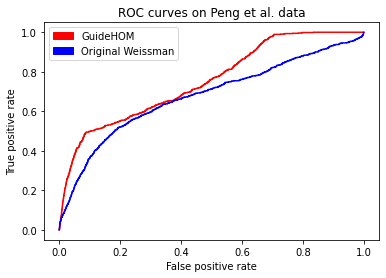

In [45]:
plt.plot(X, Y, color="red")
plt.plot(X_2, Y_2, color="blue")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(
    loc="best", 
    handles=[Patch(color="red", label="GuideHOM"), Patch(color="blue", label="Original Weissman")]
)
plt.title("ROC curves on Peng et al. data")